In [60]:
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

import ahkab
import numpy as np
import matplotlib.pyplot as plt
import sympy
from sympy.abc import w
from sympy import I
import scipy, scipy.interpolate
print("We're using ahkab %s" % ahkab.__version__)

We're using ahkab 0.18


In [122]:
lpf = ahkab.Circuit('2nd Order Sallen-Key LPF')
# https://en.wikipedia.org/wiki/Sallen–Key_topology
Av = 100 #gain
lpf.add_capacitor('CL', 'out', lpf.gnd, 40e-15) #load

lpf.add_resistor('R1', 'in', 'n1', 1e3)
lpf.add_resistor('R2', 'n1', 'n2', 1e3)
lpf.add_capacitor('C1', 'n1', 'out', 1e-9)
lpf.add_capacitor('C2', 'n2', lpf.gnd, 1e-9)
lpf.add_vcvs('E1', 'out', lpf.gnd, 'n2', 'out', Av)

# we also give V1 an AC value since we wish to run an AC simulation
lpf.add_vsource('V1', 'in', lpf.gnd, dc_value=0, ac_value=1)
print(lpf)

* 2nd Order Sallen-Key LPF
CL out 0 4e-14
R1 in n1 1000
R2 n1 n2 1000
C1 n1 out 1e-09
C2 n2 0 1e-09
E1 out 0 n2 out 100
V1 in 0 type=vdc value=0 vac=1 


In [125]:
opa = ahkab.new_op()
aca = ahkab.new_ac(start=1e3, stop=1e9, points=100)
pza = ahkab.new_pz('V1', ('out', lpf.gnd), x0=None, shift=1e3)
syma = ahkab.new_symbolic(source='V1')
r = ahkab.run(lpf, [opa, aca, pza])
rs, tfs = ahkab.run(lpf, syma)['symbolic']
r['op'].keys()
r['ac'].keys()
#r['pz'].keys() #pz analysis didn't work

# Print symbolic solution
print(rs)
Hs = tfs['VOUT/V1']['gain']
print("Transfer function: %s" % Hs)
print("Poles: %s" % tfs['VOUT/V1']['poles'])
p0 = tfs['VOUT/V1']['poles'][0]
p1 = tfs['VOUT/V1']['poles'][1]

RecursionError: maximum recursion depth exceeded in comparison

In [116]:
# Evaluate w/ chosen R & C values.
# TODO: solve for these values using Sympy

R1val = 1e3
R2val = 1e3
C1val = 1e-9
C2val = 1e-9

s, R1, R2, C1, C2 = rs.as_symbols('s R1 R2 C1 C2')
HS = sympy.lambdify(w, Hs.subs({s:I*w*2*np.pi, R1:R1val, R2:R2val, C1:C1val, C2:C2val}))
p0s = np.abs(p0.subs({R1:R1val, R2:R2val, C1:C1val, C2:C2val}))/2/np.pi
p1s = np.abs(p1.subs({R1:R1val, R2:R2val, C1:C1val, C2:C2val}))/2/np.pi
print("First pole: %g Hz" % p0s)
print("Second pole: %g Hz" % p1s)

First pole: 159155 Hz
Second pole: 159155 Hz


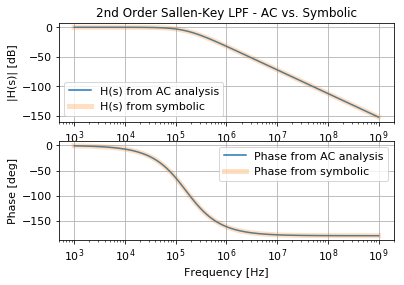

In [117]:
fig = plt.figure()
plt.subplot(211)
plt.semilogx(r['ac']['f'], 20*np.log10(np.abs(r['ac']['Vout'])), '-', label='H(s) from AC analysis')
plt.semilogx(r['ac']['f'], 20*np.log10(np.abs(HS(r['ac'].get_x()))), '-', lw=5, alpha=.25, label='H(s) from symbolic')
plt.ylabel('|H(s)| [dB]')
plt.title(lpf.title + " - AC vs. Symbolic")
plt.legend(); plt.grid(True);
plt.subplot(212)
plt.semilogx(r['ac']['f'], 180/np.pi*np.angle(r['ac']['Vout']), '-', label='Phase from AC analysis')
plt.semilogx(r['ac']['f'], 180/np.pi*(np.angle(HS(r['ac'].get_x()))), '-', lw=5, alpha=.25, label='Phase from symbolic')
plt.xlabel('Frequency [Hz]')
plt.ylabel('Phase [deg]')
#fig.savefig('ac_plot.png')
plt.legend(); plt.grid(True);
plt.show();

In [118]:
# DC gain
dc_gain = 20*np.log10(np.abs(r['ac']['Vout'][0]))
print("DC gain: %g dB" % (dc_gain))

# Normalize the output to the low frequency value and convert to array
norm_out = np.abs(r['ac']['Vout'])/np.abs(r['ac']['Vout']).max()
# Convert to dB
norm_out_db = 20*np.log10(norm_out)
# Get frequencies
frequencies = r['ac']['f']
# call scipy to interpolate
norm_out_db_interpolated = scipy.interpolate.interp1d(frequencies, norm_out_db)

print("Maximum attenuation in the pass band (0-%g Hz) is %g dB" % (20e6, -1.0*norm_out_db_interpolated(20e6)))
print("Minimum attenuation in the stop band (%g Hz - Inf) is %g dB" % (200e6, -1.0*norm_out_db_interpolated(200e6)))

DC gain: -0.000342924 dB
Maximum attenuation in the pass band (0-2e+07 Hz) is 83.9631 dB
Minimum attenuation in the stop band (2e+08 Hz - Inf) is 123.926 dB
